In [101]:
#r "nuget: xunit, 2.8.1"
#r "nuget:ScottPlot, 5.0.35"

using Xunit;
using Microsoft.DotNet.Interactive.Formatting;
using System;
using System.Collections.Concurrent;
using System.Collections.Generic;
using System.Diagnostics;
using System.Linq;
using System.Threading;
using ScottPlot;

Formatter.Register(typeof(ScottPlot.Plot), (plot, writer) =>
    writer.Write(((ScottPlot.Plot)plot).GetImageHtml(600, 600)), HtmlFormatter.MimeType)

Installed Packages ScottPlot, 5.0.35 xunit, 2.8.1

In [102]:
static double MeasureBlockingCollection(int count)
{
    var collection = new BlockingCollection<int>();
    var stopwatch = new Stopwatch();
    var startSignal = new ManualResetEvent(false);
    var endSignal = new ManualResetEvent(false);

    var producer = new Thread(() =>
    {
        startSignal.WaitOne();
        for (int i = 0; i < count; i++)
        {
            collection.Add(i);
        }
        collection.CompleteAdding();
    });
     var consumer = new Thread(() =>
    {
        startSignal.WaitOne();
        foreach (var item in collection.GetConsumingEnumerable())
        {
            // Consume item
        }
        endSignal.Set();
    });

    producer.Start();
    consumer.Start();

    startSignal.Set();
    stopwatch.Start();

    endSignal.WaitOne();
    stopwatch.Stop();

    return stopwatch.Elapsed.TotalMilliseconds;
}

    

In [103]:
static double MeasureConcurrentQueue(int count)
{
    var queue = new ConcurrentQueue<int>();
    var stopwatch = new Stopwatch();
    var startSignal = new ManualResetEvent(false);
    var endSignal = new ManualResetEvent(false);

    var producer = new Thread(() =>
    {
        startSignal.WaitOne();
        for (int i = 0; i < count; i++)
        {
            queue.Enqueue(i);
        }
    });

    var consumer = new Thread(() =>
    {
        startSignal.WaitOne();
        int item;
        for (int i = 0; i < count; i++)
        {
            while (!queue.TryDequeue(out item))
            {
                Thread.SpinWait(1);
            }
        }
        endSignal.Set();
    });

    producer.Start();
    consumer.Start();

    startSignal.Set();
    stopwatch.Start();

    endSignal.WaitOne();
    stopwatch.Stop();

    return stopwatch.Elapsed.TotalMilliseconds;
}

In [104]:
static double MeasureNonThreadSafeQueue(int count)
{
    var queue = new Queue<int>();
    var stopwatch = new Stopwatch();

    stopwatch.Start();
    for (int i = 0; i < count; i++)
    {
        queue.Enqueue(i);
    }
    for (int i = 0; i < count; i++)
    {
        queue.Dequeue();
    }
    stopwatch.Stop();

    return stopwatch.Elapsed.TotalMilliseconds;
}

BlockingCollection average time: 181.64358000000001 ms
ConcurrentQueue average time: 13.912140000000003 ms
Non-thread-safe Queue average time: 6.193630000000001 ms
Speed_percentage: 224.62013391177712



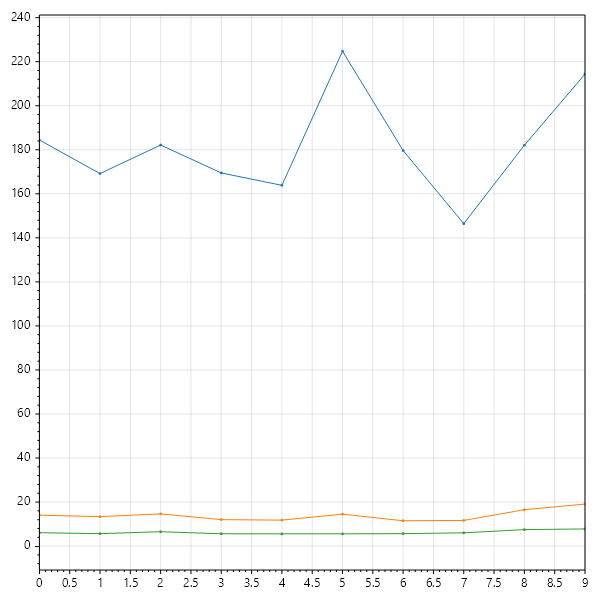

In [105]:
const int count = 1000000;
const int iterations = 10;

var blockingCollectionTimes = new List<double>();
var concurrentQueueTimes = new List<double>();
var nonThreadSafeQueueTimes = new List<double>();

for (int i = 0; i < iterations; i++)
{
    blockingCollectionTimes.Add(MeasureBlockingCollection(count));
    concurrentQueueTimes.Add(MeasureConcurrentQueue(count));
    nonThreadSafeQueueTimes.Add(MeasureNonThreadSafeQueue(count));
}

Console.WriteLine("BlockingCollection average time: " + blockingCollectionTimes.Average() + " ms");
Console.WriteLine("ConcurrentQueue average time: " + concurrentQueueTimes.Average() + " ms");
Console.WriteLine("Non-thread-safe Queue average time: " + nonThreadSafeQueueTimes.Average() + " ms");


var speed_percentage=(Math.Min(blockingCollectionTimes.Average(),concurrentQueueTimes.Average())*100)/nonThreadSafeQueueTimes.Average();
Console.WriteLine("Speed_percentage: "+speed_percentage);

ScottPlot.Plot plot = new();

plot.Add.Signal(blockingCollectionTimes);
plot.Add.Signal(concurrentQueueTimes);
plot.Add.Signal(nonThreadSafeQueueTimes);
plot.Axes.SetLimits(0, 9);
plot.SavePng("graph.png", 600, 600);
plot
